In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [5]:
base_dir = '/Users/hugofluhr/data/LH_dev'
sub_ids = load_participant_list(base_dir)

In [6]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=False) for sub_id in sub_ids]

/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:166: UserWarning: Last 1 trial(s) of block had no response, filling with 0


In [8]:
N_subjects = len(subjects)
RL_CK_corr = np.zeros((N_subjects, 3))

In [13]:
for i, sub in enumerate(subjects):
    for j, run in enumerate(sub.runs):
        # load the block
        block = getattr(sub, run)
        # compute the correlation between the parametric modulator and the RL signal
        RL_CK_corr[i, j] = np.corrcoef(block.extended_trials.first_stim_value_rl, block.extended_trials.first_stim_value_ck)[0, 1]

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'Correlation between RL and CK values of the first stimuli in each run')

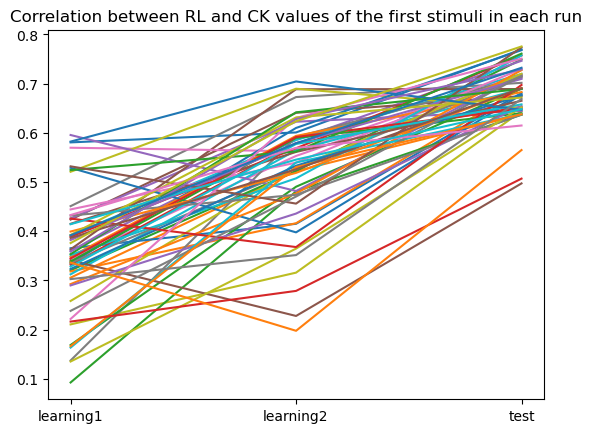

In [19]:
plt.plot([r for r in sub.runs],RL_CK_corr.T)
plt.title('Correlation between RL and CK values of the first stimuli in each run')
#plt.legend([r for r in sub.runs])